In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from xgboost import XGBClassifier

Load Data

In [312]:
df = pd.read_csv("./csgo_games.csv")
df.head()

,match_date,team_1,team_2,t1_points,t2_points,t1_world_rank,t2_world_rank,t1_h2h_win_perc,t2_h2h_win_perc,winner,...,t2_player5_dpr,t2_player5_spr,t2_player5_opk_ratio,t2_player5_opk_rating,t2_player5_wins_perc_after_fk,t2_player5_fk_perc_in_wins,t2_player5_multikill_perc,t2_player5_rating_at_least_one_perc,t2_player5_is_sniper,t2_player5_clutch_win_perc
0,2016-12-18,CLOUD9,HELLRAISERS,13,16,9,20,0.500000,0.500000,t2,...,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,False,0.666667
1,2016-12-18,IMMORTALS,G2,17,19,13,10,0.500000,0.500000,t2,...,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,True,0.406250
2,2016-12-18,MOUSESPORTS,IMMORTALS,16,3,12,13,0.500000,0.500000,t1,...,0.67,0.07,0.79,0.94,0.723,0.129,0.148257,0.526,False,0.733333
3,2016-12-18,DIGNITAS,G2,16,9,6,10,0.416667,0.583333,t1,...,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,True,0.406250
4,2016-12-18,OPTIC,HELLRAISERS,16,10,4,20,0.500000,0.500000,t1,...,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,False,0.666667


Remove irrelevant features


In [313]:
df.drop(['match_date', 'team_1', 'team_2', 't1_points', 't2_points'], axis=1, inplace=True)
df.head()

,t1_world_rank,t2_world_rank,t1_h2h_win_perc,t2_h2h_win_perc,winner,t1_player1_rating,t1_player1_impact,t1_player1_kdr,t1_player1_dmr,t1_player1_kpr,...,t2_player5_dpr,t2_player5_spr,t2_player5_opk_ratio,t2_player5_opk_rating,t2_player5_wins_perc_after_fk,t2_player5_fk_perc_in_wins,t2_player5_multikill_perc,t2_player5_rating_at_least_one_perc,t2_player5_is_sniper,t2_player5_clutch_win_perc
0,9,20,0.500000,0.500000,t2,1.24,1.29,1.24,87.0,0.83,...,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,False,0.666667
1,13,10,0.500000,0.500000,t2,1.21,1.24,1.35,78.7,0.78,...,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,True,0.406250
2,12,13,0.500000,0.500000,t1,1.18,1.42,1.13,83.8,0.78,...,0.67,0.07,0.79,0.94,0.723,0.129,0.148257,0.526,False,0.733333
3,6,10,0.416667,0.583333,t1,1.19,1.17,1.24,84.1,0.77,...,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,True,0.406250
4,4,20,0.500000,0.500000,t1,1.19,1.21,1.19,81.4,0.78,...,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,False,0.666667


Get missing data cells

In [314]:
# Identify columns with any empty values (NaN or empty strings) and filter the DataFrame
df_filtered_columns = df.loc[:, df.isna().any(axis=0) | (df == '').any(axis=0)]

# Find rows with any empty values in the filtered DataFrame
rows_with_empty = df_filtered_columns[df_filtered_columns.isna().any(axis=1) | (df_filtered_columns == '').any(axis=1)]

# Get indices of these rows and their count
rows_with_empty_indices = rows_with_empty.index

# Display the first few rows with empty values in the filtered columns
rows_with_empty.head()


,t1_player5_wins_perc_after_fk,t2_player3_wins_perc_after_fk,t2_player5_wins_perc_after_fk
383,NaN,0.729,0.755
731,0.816,0.736,NaN
735,NaN,0.798,0.764
1994,0.753,NaN,0.693


In [315]:
df.drop(rows_with_empty_indices, inplace=True)

Convert "winner" label to numeric value - 0 means a win for t1 and 1 means a win for t2

In [316]:
df["winner"] = (df["winner"] == "t2").astype(int)
df['winner'].head()

0    1
1    1
2    0
3    0
4    0
Name: winner, dtype: int64

Ranking

In [317]:
df['rank_difference'] = df['t1_world_rank'].astype(int) - df['t2_world_rank'].astype(int)
df.head()

,t1_world_rank,t2_world_rank,t1_h2h_win_perc,t2_h2h_win_perc,winner,t1_player1_rating,t1_player1_impact,t1_player1_kdr,t1_player1_dmr,t1_player1_kpr,...,t2_player5_spr,t2_player5_opk_ratio,t2_player5_opk_rating,t2_player5_wins_perc_after_fk,t2_player5_fk_perc_in_wins,t2_player5_multikill_perc,t2_player5_rating_at_least_one_perc,t2_player5_is_sniper,t2_player5_clutch_win_perc,rank_difference
0,9,20,0.500000,0.500000,1,1.24,1.29,1.24,87.0,0.83,...,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,False,0.666667,-11
1,13,10,0.500000,0.500000,1,1.21,1.24,1.35,78.7,0.78,...,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,True,0.406250,3
2,12,13,0.500000,0.500000,0,1.18,1.42,1.13,83.8,0.78,...,0.07,0.79,0.94,0.723,0.129,0.148257,0.526,False,0.733333,-1
3,6,10,0.416667,0.583333,0,1.19,1.17,1.24,84.1,0.77,...,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,True,0.406250,-4
4,4,20,0.500000,0.500000,0,1.19,1.21,1.19,81.4,0.78,...,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,False,0.666667,-16


Aggregate the number of snippers in each team

In [318]:
df[[f't1_player{i}_is_sniper' for i in range(1, 6)]] = df[[f't1_player{i}_is_sniper' for i in range(1, 6)]].astype(int)
df[[f't2_player{i}_is_sniper' for i in range(1, 6)]] = df[[f't2_player{i}_is_sniper' for i in range(1, 6)]].astype(int)

df['t1_snipers'] = df[[f't1_player{i}_is_sniper' for i in range(1, 6)]].sum(axis=1)
df['t2_snipers'] = df[[f't2_player{i}_is_sniper' for i in range(1, 6)]].sum(axis=1)
df['snipper_difference']=df['t1_snipers'] - df['t2_snipers']

df['t1_player1_is_sniper'] = df['t1_player1_is_sniper'].astype(int)
df['t1_player2_is_sniper'] = df['t1_player2_is_sniper'].astype(int)
df['t1_player3_is_sniper'] = df['t1_player3_is_sniper'].astype(int)
df['t1_player4_is_sniper'] = df['t1_player4_is_sniper'].astype(int)
df['t1_player5_is_sniper'] = df['t1_player5_is_sniper'].astype(int)
df['t2_player1_is_sniper'] = df['t2_player1_is_sniper'].astype(int)
df['t2_player2_is_sniper'] = df['t2_player2_is_sniper'].astype(int)
df['t2_player3_is_sniper'] = df['t2_player3_is_sniper'].astype(int)
df['t2_player4_is_sniper'] = df['t2_player4_is_sniper'].astype(int)
df['t2_player5_is_sniper'] = df['t2_player5_is_sniper'].astype(int)

df[['t1_player1_is_sniper','t1_snipers','t2_snipers', 'snipper_difference']].head()

,t1_player1_is_sniper,t1_snipers,t2_snipers,snipper_difference
0,0,1,1,0
1,1,1,2,-1
2,0,1,1,0
3,0,1,2,-1
4,1,2,1,1


Aggregate rating

In [319]:
df['t1_player_rating_avg'] = df[[f't1_player{i}_rating' for i in range(1, 6)]].mean(axis=1)
df['t2_player_rating_avg'] = df[[f't2_player{i}_rating' for i in range(1, 6)]].mean(axis=1)

df['t1_player_rating_max'] = df[[f't1_player{i}_rating' for i in range(1, 6)]].max(axis=1)
df['t2_player_rating_max'] = df[[f't2_player{i}_rating' for i in range(1, 6)]].max(axis=1)

df['t1_player_rating_min'] = df[[f't1_player{i}_rating' for i in range(1, 6)]].min(axis=1)
df['t2_player_rating_min'] = df[[f't2_player{i}_rating' for i in range(1, 6)]].min(axis=1)

df['player_rating_avg_diff'] = df['t1_player_rating_avg'] - df['t2_player_rating_avg']
df['player_rating_max_diff'] = df['t1_player_rating_max'] - df['t2_player_rating_max']
df['player_rating_min_diff'] = df['t1_player_rating_min'] - df['t2_player_rating_min']

df[['player_rating_avg_diff','player_rating_max_diff', 'player_rating_min_diff', 'winner']].head()

,player_rating_avg_diff,player_rating_max_diff,player_rating_min_diff,winner
0,0.044,0.04,0.03,1
1,0.102,0.06,0.09,1
2,-0.074,-0.03,-0.08,0
3,0.060,0.04,0.01,0
4,0.052,-0.01,0.07,0


Aggregate player impact

In [320]:
df['t1_player_impact_avg'] = df[[f't1_player{i}_impact' for i in range(1, 6)]].mean(axis=1)
df['t2_player_impact_avg'] = df[[f't2_player{i}_impact' for i in range(1, 6)]].mean(axis=1)

df['t1_player_impact_max'] = df[[f't1_player{i}_impact' for i in range(1, 6)]].max(axis=1)
df['t2_player_impact_max'] = df[[f't2_player{i}_impact' for i in range(1, 6)]].max(axis=1)

df['t1_player_impact_min'] = df[[f't1_player{i}_impact' for i in range(1, 6)]].min(axis=1)
df['t2_player_impact_min'] = df[[f't2_player{i}_impact' for i in range(1, 6)]].min(axis=1)

df['player_impact_avg_diff'] = df['t1_player_impact_avg'] - df['t2_player_impact_avg']
df['player_impact_max_diff'] = df['t1_player_impact_max'] - df['t2_player_impact_max']
df['player_impact_min_diff'] = df['t1_player_impact_min'] - df['t2_player_impact_min']

df[['player_impact_avg_diff','player_impact_max_diff','player_impact_min_diff', 'winner']].head()


,player_impact_avg_diff,player_impact_max_diff,player_impact_min_diff,winner
0,0.044,-0.11,0.12,1
1,0.112,0.10,0.12,1
2,-0.066,0.07,-0.18,0
3,0.064,0.01,0.03,0
4,0.052,-0.19,0.18,0


Aggregate player kdr

In [321]:
# prompt: aggregate player kdr of each team in the same way as how we deal with the player rating

df['t1_player_kdr_avg'] = df[[f't1_player{i}_kdr' for i in range(1, 6)]].mean(axis=1)
df['t2_player_kdr_avg'] = df[[f't2_player{i}_kdr' for i in range(1, 6)]].mean(axis=1)

df['t1_player_kdr_max'] = df[[f't1_player{i}_kdr' for i in range(1, 6)]].max(axis=1)
df['t2_player_kdr_max'] = df[[f't2_player{i}_kdr' for i in range(1, 6)]].max(axis=1)

df['t1_player_kdr_min'] = df[[f't1_player{i}_kdr' for i in range(1, 6)]].min(axis=1)
df['t2_player_kdr_min'] = df[[f't2_player{i}_kdr' for i in range(1, 6)]].min(axis=1)

df['player_kdr_avg_diff'] = df['t1_player_kdr_avg'] - df['t2_player_kdr_avg']
df['player_kdr_max_diff'] = df['t1_player_kdr_max'] - df['t2_player_kdr_max']
df['player_kdr_min_diff'] = df['t1_player_kdr_min'] - df['t2_player_kdr_min']

df[['player_kdr_avg_diff','player_kdr_max_diff','player_kdr_min_diff', 'winner']].head()


,player_kdr_avg_diff,player_kdr_max_diff,player_kdr_min_diff,winner
0,0.056,0.13,-0.02,1
1,0.152,0.23,0.09,1
2,-0.116,-0.22,-0.10,0
3,0.090,0.12,-0.02,0
4,0.052,0.08,0.05,0


Aggregate player dmr

In [322]:
df['t1_player_dmr_avg'] = df[[f't1_player{i}_dmr' for i in range(1, 6)]].mean(axis=1)
df['t2_player_dmr_avg'] = df[[f't2_player{i}_dmr' for i in range(1, 6)]].mean(axis=1)

df['t1_player_dmr_max'] = df[[f't1_player{i}_dmr' for i in range(1, 6)]].max(axis=1)
df['t2_player_dmr_max'] = df[[f't2_player{i}_dmr' for i in range(1, 6)]].max(axis=1)

df['t1_player_dmr_min'] = df[[f't1_player{i}_dmr' for i in range(1, 6)]].min(axis=1)
df['t2_player_dmr_min'] = df[[f't2_player{i}_dmr' for i in range(1, 6)]].min(axis=1)

df['player_dmr_avg_diff'] = df['t1_player_dmr_avg'] - df['t2_player_dmr_avg']
df['player_dmr_max_diff'] = df['t1_player_dmr_max'] - df['t2_player_dmr_max']
df['player_dmr_min_diff'] = df['t1_player_dmr_min'] - df['t2_player_dmr_min']

df[['player_dmr_avg_diff','player_dmr_max_diff','player_dmr_min_diff', 'winner']].head()


,player_dmr_avg_diff,player_dmr_max_diff,player_dmr_min_diff,winner
0,1.08,-3.1,-1.1,1
1,4.90,5.0,6.8,1
2,-4.38,-5.5,-3.7,0
3,2.02,1.2,3.3,0
4,1.80,-8.7,6.9,0


Aggregate player kpr

In [323]:
df['t1_player_kpr_avg'] = df[[f't1_player{i}_kpr' for i in range(1, 6)]].mean(axis=1)
df['t2_player_kpr_avg'] = df[[f't2_player{i}_kpr' for i in range(1, 6)]].mean(axis=1)

df['t1_player_kpr_max'] = df[[f't1_player{i}_kpr' for i in range(1, 6)]].max(axis=1)
df['t2_player_kpr_max'] = df[[f't2_player{i}_kpr' for i in range(1, 6)]].max(axis=1)

df['t1_player_kpr_min'] = df[[f't1_player{i}_kpr' for i in range(1, 6)]].min(axis=1)
df['t2_player_kpr_min'] = df[[f't2_player{i}_kpr' for i in range(1, 6)]].min(axis=1)

df['player_kpr_avg_diff'] = df['t1_player_kpr_avg'] - df['t2_player_kpr_avg']
df['player_kpr_max_diff'] = df['t1_player_kpr_max'] - df['t2_player_kpr_max']
df['player_kpr_min_diff'] = df['t1_player_kpr_min'] - df['t2_player_kpr_min']

df[['player_kpr_avg_diff','player_kpr_max_diff', 'player_kpr_min_diff','winner']].head()

,player_kpr_avg_diff,player_kpr_max_diff,player_kpr_min_diff,winner
0,0.018,0.04,0.02,1
1,0.042,0.02,0.05,1
2,-0.040,-0.03,-0.04,0
3,0.018,-0.01,0.01,0
4,0.020,-0.01,0.05,0


Aggregate player apr

In [324]:
df['t1_player_apr_avg'] = df[[f't1_player{i}_apr' for i in range(1, 6)]].mean(axis=1)
df['t2_player_apr_avg'] = df[[f't2_player{i}_apr' for i in range(1, 6)]].mean(axis=1)

df['t1_player_apr_max'] = df[[f't1_player{i}_apr' for i in range(1, 6)]].max(axis=1)
df['t2_player_apr_max'] = df[[f't2_player{i}_apr' for i in range(1, 6)]].max(axis=1)

df['t1_player_apr_min'] = df[[f't1_player{i}_apr' for i in range(1, 6)]].min(axis=1)
df['t2_player_apr_min'] = df[[f't2_player{i}_apr' for i in range(1, 6)]].min(axis=1)

df['player_apr_avg_diff'] = df['t1_player_apr_avg'] - df['t2_player_apr_avg']
df['player_apr_max_diff'] = df['t1_player_apr_max'] - df['t2_player_apr_max']
df['player_apr_min_diff'] = df['t1_player_apr_min'] - df['t2_player_apr_min']

df[['player_apr_avg_diff','player_apr_max_diff','player_apr_min_diff', 'winner']].head()


,player_apr_avg_diff,player_apr_max_diff,player_apr_min_diff,winner
0,0.012,0.02,0.01,1
1,0.028,0.04,0.00,1
2,-0.022,-0.02,-0.02,0
3,0.014,0.02,0.00,0
4,0.022,0.01,0.04,0


Aggregate player dpr

In [325]:
df['t1_player_dpr_avg'] = df[[f't1_player{i}_dpr' for i in range(1, 6)]].mean(axis=1)
df['t2_player_dpr_avg'] = df[[f't2_player{i}_dpr' for i in range(1, 6)]].mean(axis=1)

df['t1_player_dpr_max'] = df[[f't1_player{i}_dpr' for i in range(1, 6)]].max(axis=1)
df['t2_player_dpr_max'] = df[[f't2_player{i}_dpr' for i in range(1, 6)]].max(axis=1)

df['t1_player_dpr_min'] = df[[f't1_player{i}_dpr' for i in range(1, 6)]].min(axis=1)
df['t2_player_dpr_min'] = df[[f't2_player{i}_dpr' for i in range(1, 6)]].min(axis=1)

df['player_dpr_avg_diff'] = df['t1_player_dpr_avg'] - df['t2_player_dpr_avg']
df['player_dpr_max_diff'] = df['t1_player_dpr_max'] - df['t2_player_dpr_max']
df['player_dpr_min_diff'] = df['t1_player_dpr_min'] - df['t2_player_dpr_min']

df[['player_dpr_avg_diff','player_dpr_max_diff','player_dpr_min_diff', 'winner']].head()


,player_dpr_avg_diff,player_dpr_max_diff,player_dpr_min_diff,winner
0,-0.018,-0.02,-0.06,1
1,-0.052,0.00,-0.10,1
2,0.028,-0.01,0.06,0
3,-0.036,0.00,-0.07,0
4,-0.012,-0.04,0.01,0


Aggregate player spr

In [326]:
df['t1_player_spr_avg'] = df[[f't1_player{i}_spr' for i in range(1, 6)]].mean(axis=1)
df['t2_player_spr_avg'] = df[[f't2_player{i}_spr' for i in range(1, 6)]].mean(axis=1)

df['t1_player_spr_max'] = df[[f't1_player{i}_spr' for i in range(1, 6)]].max(axis=1)
df['t2_player_spr_max'] = df[[f't2_player{i}_spr' for i in range(1, 6)]].max(axis=1)

df['t1_player_spr_min'] = df[[f't1_player{i}_spr' for i in range(1, 6)]].min(axis=1)
df['t2_player_spr_min'] = df[[f't2_player{i}_spr' for i in range(1, 6)]].min(axis=1)

df['player_spr_avg_diff'] = df['t1_player_spr_avg'] - df['t2_player_spr_avg']
df['player_spr_max_diff'] = df['t1_player_spr_max'] - df['t2_player_spr_max']
df['player_spr_min_diff'] = df['t1_player_spr_min'] - df['t2_player_spr_min']

df[['player_spr_avg_diff','player_spr_max_diff','player_spr_min_diff', 'winner']].head()

,player_spr_avg_diff,player_spr_max_diff,player_spr_min_diff,winner
0,-0.002,0.00,0.01,1
1,-0.016,-0.04,-0.02,1
2,0.008,0.02,0.01,0
3,-0.012,-0.04,-0.01,0
4,0.010,0.00,0.01,0


Aggregate player opk ratio

In [327]:
df['t1_player_opk_ratio_avg'] = df[[f't1_player{i}_opk_ratio' for i in range(1, 6)]].mean(axis=1)
df['t2_player_opk_ratio_avg'] = df[[f't2_player{i}_opk_ratio' for i in range(1, 6)]].mean(axis=1)

df['t1_player_opk_ratio_max'] = df[[f't1_player{i}_opk_ratio' for i in range(1, 6)]].max(axis=1)
df['t2_player_opk_ratio_max'] = df[[f't2_player{i}_opk_ratio' for i in range(1, 6)]].max(axis=1)

df['t1_player_opk_ratio_min'] = df[[f't1_player{i}_opk_ratio' for i in range(1, 6)]].min(axis=1)
df['t2_player_opk_ratio_min'] = df[[f't2_player{i}_opk_ratio' for i in range(1, 6)]].min(axis=1)

df['player_opk_ratio_avg_diff'] = df['t1_player_opk_ratio_avg'] - df['t2_player_opk_ratio_avg']
df['player_opk_ratio_max_diff'] = df['t1_player_opk_ratio_max'] - df['t2_player_opk_ratio_max']
df['player_opk_ratio_min_diff'] = df['t1_player_opk_ratio_min'] - df['t2_player_opk_ratio_min']

df[['player_opk_ratio_avg_diff','player_opk_ratio_max_diff','player_opk_ratio_min_diff', 'winner']].head()


,player_opk_ratio_avg_diff,player_opk_ratio_max_diff,player_opk_ratio_min_diff,winner
0,0.122,0.65,-0.04,1
1,0.226,0.53,0.00,1
2,-0.148,-0.23,-0.13,0
3,0.094,0.19,-0.08,0
4,0.038,-0.12,0.07,0


Aggregate player opk rating

In [328]:
df['t1_player_opk_rating_avg'] = df[[f't1_player{i}_opk_rating' for i in range(1, 6)]].mean(axis=1)
df['t2_player_opk_rating_avg'] = df[[f't2_player{i}_opk_rating' for i in range(1, 6)]].mean(axis=1)

df['t1_player_opk_rating_max'] = df[[f't1_player{i}_opk_rating' for i in range(1, 6)]].max(axis=1)
df['t2_player_opk_rating_max'] = df[[f't2_player{i}_opk_rating' for i in range(1, 6)]].max(axis=1)

df['t1_player_opk_rating_min'] = df[[f't1_player{i}_opk_rating' for i in range(1, 6)]].min(axis=1)
df['t2_player_opk_rating_min'] = df[[f't2_player{i}_opk_rating' for i in range(1, 6)]].min(axis=1)

df['player_opk_rating_avg_diff'] = df['t1_player_opk_rating_avg'] - df['t2_player_opk_rating_avg']
df['player_opk_rating_max_diff'] = df['t1_player_opk_rating_max'] - df['t2_player_opk_rating_max']
df['player_opk_rating_min_diff'] = df['t1_player_opk_rating_min'] - df['t2_player_opk_rating_min']

df[['player_opk_rating_avg_diff','player_opk_rating_max_diff', 'player_opk_rating_min_diff', 'winner']].head()


/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/2776659095.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t1_player_opk_rating_max'] = df[[f't1_player{i}_opk_rating' for i in range(1, 6)]].max(axis=1)
/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/2776659095.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t2_player_opk_rating_max'] = df[[f't2_player{i}_opk_rating' for i in range(1, 6)]].max(axis=1)
/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/2776659095.py:7

,player_opk_rating_avg_diff,player_opk_rating_max_diff,player_opk_rating_min_diff,winner
0,0.006,-0.11,0.05,1
1,0.062,0.03,0.07,1
2,-0.030,0.09,-0.17,0
3,0.024,-0.04,0.02,0
4,0.014,-0.06,0.06,0


aggregate player wins perc after fk

In [329]:
df['t1_player_wins_perc_after_fk_avg'] = df[[f't1_player{i}_wins_perc_after_fk' for i in range(1, 6)]].mean(axis=1)
df['t2_player_wins_perc_after_fk_avg'] = df[[f't2_player{i}_wins_perc_after_fk' for i in range(1, 6)]].mean(axis=1)

df['t1_player_wins_perc_after_fk_max'] = df[[f't1_player{i}_wins_perc_after_fk' for i in range(1, 6)]].max(axis=1)
df['t2_player_wins_perc_after_fk_max'] = df[[f't2_player{i}_wins_perc_after_fk' for i in range(1, 6)]].max(axis=1)

df['t1_player_wins_perc_after_fk_min'] = df[[f't1_player{i}_wins_perc_after_fk' for i in range(1, 6)]].min(axis=1)
df['t2_player_wins_perc_after_fk_min'] = df[[f't2_player{i}_wins_perc_after_fk' for i in range(1, 6)]].min(axis=1)

df['player_wins_perc_after_fk_avg_diff'] = df['t1_player_wins_perc_after_fk_avg'] - df['t2_player_wins_perc_after_fk_avg']
df['player_wins_perc_after_fk_max_diff'] = df['t1_player_wins_perc_after_fk_max'] - df['t2_player_wins_perc_after_fk_max']
df['player_wins_perc_after_fk_min_diff'] = df['t1_player_wins_perc_after_fk_min'] - df['t2_player_wins_perc_after_fk_min']

df[['player_wins_perc_after_fk_avg_diff','player_wins_perc_after_fk_max_diff','player_wins_perc_after_fk_min_diff', 'winner']].head()


/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/1264664076.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t1_player_wins_perc_after_fk_avg'] = df[[f't1_player{i}_wins_perc_after_fk' for i in range(1, 6)]].mean(axis=1)
/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/1264664076.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t2_player_wins_perc_after_fk_avg'] = df[[f't2_player{i}_wins_perc_after_fk' for i in range(1, 6)]].mean(axis=1)
/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn

,player_wins_perc_after_fk_avg_diff,player_wins_perc_after_fk_max_diff,player_wins_perc_after_fk_min_diff,winner
0,0.0260,0.018,0.022,1
1,0.0728,0.076,0.085,1
2,-0.0414,-0.030,-0.056,0
3,0.0542,0.054,0.060,0
4,-0.0102,-0.061,0.005,0


Aggregate player multikill perc

In [330]:
df['t1_player_multikill_perc_avg'] = df[[f't1_player{i}_multikill_perc' for i in range(1, 6)]].mean(axis=1)
df['t2_player_multikill_perc_avg'] = df[[f't2_player{i}_multikill_perc' for i in range(1, 6)]].mean(axis=1)

df['t1_player_multikill_perc_max'] = df[[f't1_player{i}_multikill_perc' for i in range(1, 6)]].max(axis=1)
df['t2_player_multikill_perc_max'] = df[[f't2_player{i}_multikill_perc' for i in range(1, 6)]].max(axis=1)

df['t1_player_multikill_perc_min'] = df[[f't1_player{i}_multikill_perc' for i in range(1, 6)]].min(axis=1)
df['t2_player_multikill_perc_min'] = df[[f't2_player{i}_multikill_perc' for i in range(1, 6)]].min(axis=1)

df['player_multikill_perc_avg_diff'] = df['t1_player_multikill_perc_avg'] - df['t2_player_multikill_perc_avg']
df['player_multikill_perc_max_diff'] = df['t1_player_multikill_perc_max'] - df['t2_player_multikill_perc_max']
df['player_multikill_perc_min_diff'] = df['t1_player_multikill_perc_min'] - df['t2_player_multikill_perc_min']

df[['player_multikill_perc_avg_diff','player_multikill_perc_max_diff','player_multikill_perc_min_diff', 'winner']].head()


/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/1187820184.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t1_player_multikill_perc_avg'] = df[[f't1_player{i}_multikill_perc' for i in range(1, 6)]].mean(axis=1)
/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/1187820184.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t2_player_multikill_perc_avg'] = df[[f't2_player{i}_multikill_perc' for i in range(1, 6)]].mean(axis=1)
/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_819

,player_multikill_perc_avg_diff,player_multikill_perc_max_diff,player_multikill_perc_min_diff,winner
0,0.010610,0.019087,0.011698,1
1,0.006910,0.008648,0.012447,1
2,-0.005355,0.003481,-0.008257,0
3,0.003392,-0.000560,-0.003451,0
4,0.009436,-0.006060,0.021604,0


Aggregate player rating at least one perc

In [331]:
df['t1_player_rating_at_least_one_perc_avg'] = df[[f't1_player{i}_rating_at_least_one_perc' for i in range(1, 6)]].mean(axis=1)
df['t2_player_rating_at_least_one_perc_avg'] = df[[f't2_player{i}_rating_at_least_one_perc' for i in range(1, 6)]].mean(axis=1)

df['t1_player_rating_at_least_one_perc_max'] = df[[f't1_player{i}_rating_at_least_one_perc' for i in range(1, 6)]].max(axis=1)
df['t2_player_rating_at_least_one_perc_max'] = df[[f't2_player{i}_rating_at_least_one_perc' for i in range(1, 6)]].max(axis=1)

df['t1_player_rating_at_least_one_perc_min'] = df[[f't1_player{i}_rating_at_least_one_perc' for i in range(1, 6)]].min(axis=1)
df['t2_player_rating_at_least_one_perc_min'] = df[[f't2_player{i}_rating_at_least_one_perc' for i in range(1, 6)]].min(axis=1)

df['player_rating_at_least_one_perc_avg_diff'] = df['t1_player_rating_at_least_one_perc_avg'] - df['t2_player_rating_at_least_one_perc_avg']
df['player_rating_at_least_one_perc_max_diff'] = df['t1_player_rating_at_least_one_perc_max'] - df['t2_player_rating_at_least_one_perc_max']
df['player_rating_at_least_one_perc_min_diff'] = df['t1_player_rating_at_least_one_perc_min'] - df['t2_player_rating_at_least_one_perc_min']

df[['player_rating_at_least_one_perc_avg_diff','player_rating_at_least_one_perc_max_diff','player_rating_at_least_one_perc_min_diff', 'winner']].head()


/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/3680080503.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t1_player_rating_at_least_one_perc_avg'] = df[[f't1_player{i}_rating_at_least_one_perc' for i in range(1, 6)]].mean(axis=1)
/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/3680080503.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t2_player_rating_at_least_one_perc_avg'] = df[[f't2_player{i}_rating_at_least_one_perc' for i in range(1, 6)]].mean(axis=1)
/var/folders/vl/3q9b07

,player_rating_at_least_one_perc_avg_diff,player_rating_at_least_one_perc_max_diff,player_rating_at_least_one_perc_min_diff,winner
0,0.0736,0.025,0.086,1
1,0.1496,0.124,0.104,1
2,-0.0964,-0.031,-0.053,0
3,0.1084,0.122,0.017,0
4,0.0804,-0.002,0.116,0


Aggregate player clutch win perc

In [332]:
df['t1_player_clutch_win_perc_avg'] = df[[f't1_player{i}_clutch_win_perc' for i in range(1, 6)]].mean(axis=1)
df['t2_player_clutch_win_perc_avg'] = df[[f't2_player{i}_clutch_win_perc' for i in range(1, 6)]].mean(axis=1)

df['t1_player_clutch_win_perc_max'] = df[[f't1_player{i}_clutch_win_perc' for i in range(1, 6)]].max(axis=1)
df['t2_player_clutch_win_perc_max'] = df[[f't2_player{i}_clutch_win_perc' for i in range(1, 6)]].max(axis=1)

df['t1_player_clutch_win_perc_min'] = df[[f't1_player{i}_clutch_win_perc' for i in range(1, 6)]].min(axis=1)
df['t2_player_clutch_win_perc_min'] = df[[f't2_player{i}_clutch_win_perc' for i in range(1, 6)]].min(axis=1)

df['player_clutch_win_perc_avg_diff'] = df['t1_player_clutch_win_perc_avg'] - df['t2_player_clutch_win_perc_avg']
df['player_clutch_win_perc_max_diff'] = df['t1_player_clutch_win_perc_max'] - df['t2_player_clutch_win_perc_max']
df['player_clutch_win_perc_min_diff'] = df['t1_player_clutch_win_perc_min'] - df['t2_player_clutch_win_perc_min']

df[['player_clutch_win_perc_avg_diff','player_clutch_win_perc_max_diff','player_clutch_win_perc_min_diff', 'winner']].head()


/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/2633629092.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t1_player_clutch_win_perc_avg'] = df[[f't1_player{i}_clutch_win_perc' for i in range(1, 6)]].mean(axis=1)
/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/2633629092.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t2_player_clutch_win_perc_avg'] = df[[f't2_player{i}_clutch_win_perc' for i in range(1, 6)]].mean(axis=1)
/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel

,player_clutch_win_perc_avg_diff,player_clutch_win_perc_max_diff,player_clutch_win_perc_min_diff,winner
0,0.054151,0.043103,0.065657,1
1,0.149229,0.171053,0.152174,1
2,-0.152156,-0.178571,-0.166667,0
3,0.212352,0.151822,0.309317,0
4,-0.035427,-0.025862,-0.121212,0


Move "winner" to the end

In [333]:
cols = list(df.columns)
cols.insert(len(cols), cols.pop(cols.index('winner')))
df = df[cols]

Scale Data

In [334]:
def scale_dataset(dataframe, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = pd.DataFrame(np.hstack((X, np.reshape(y, (-1, 1)))),columns=dataframe.columns)

  return data

In [335]:
df = scale_dataset(df)
df['winner']=df['winner'].astype(int)
df.head()

,t1_world_rank,t2_world_rank,t1_h2h_win_perc,t2_h2h_win_perc,t1_player1_rating,t1_player1_impact,t1_player1_kdr,t1_player1_dmr,t1_player1_kpr,t1_player1_apr,...,t1_player_clutch_win_perc_avg,t2_player_clutch_win_perc_avg,t1_player_clutch_win_perc_max,t2_player_clutch_win_perc_max,t1_player_clutch_win_perc_min,t2_player_clutch_win_perc_min,player_clutch_win_perc_avg_diff,player_clutch_win_perc_max_diff,player_clutch_win_perc_min_diff,winner
0,0.030054,1.809946,-0.077581,0.077581,0.807303,0.561488,0.256619,1.048847,1.316437,0.534312,...,1.561234,0.733252,0.415774,-0.010151,1.456508,0.902079,0.594881,0.301273,0.451525,1
1,0.750788,0.029324,-0.077581,0.077581,0.364755,0.089673,1.233270,-0.785800,0.145535,-0.751776,...,0.486626,-1.813220,-0.009776,-1.696377,0.502657,-0.871935,1.616698,1.194758,1.016282,1
2,0.570604,0.563511,-0.077581,0.077581,-0.077794,1.788205,-0.720032,0.341513,0.145535,-0.323080,...,-1.815674,0.474635,-1.772768,-0.010151,-0.928120,0.494056,-1.622327,-1.246711,-1.065008,0
3,-0.510496,0.029324,-0.441980,0.441980,0.069722,-0.570867,0.256619,0.407826,-0.088646,0.105616,...,1.441752,-1.813220,-0.199637,-1.696377,1.851676,-0.871935,2.295089,1.060467,2.042061,0
4,-0.870862,1.809946,-0.077581,0.077581,0.069722,-0.193415,-0.187313,-0.188987,0.145535,0.534312,...,0.205811,0.733252,-0.265106,-0.010151,-0.147696,0.902079,-0.367829,-0.180322,-0.768295,0


Correlational Analysis

In [336]:
correlations = df.corr()['winner'].abs().sort_values(ascending=False)
pd.set_option('display.max_rows', 500)
print(correlations)

winner                                      1.000000
player_kdr_avg_diff                         0.202436
player_rating_avg_diff                      0.195169
player_dpr_avg_diff                         0.193772
player_dmr_avg_diff                         0.189684
rank_difference                             0.189229
player_impact_avg_diff                      0.187675
player_rating_at_least_one_perc_avg_diff    0.187475
player_kpr_avg_diff                         0.184984
player_multikill_perc_avg_diff              0.179705
player_dpr_max_diff                         0.161167
player_dpr_min_diff                         0.154655
t1_player_kdr_avg                           0.150212
player_kdr_min_diff                         0.147314
player_rating_min_diff                      0.146171
t1_world_rank                               0.142430
player_kdr_max_diff                         0.141652
player_wins_perc_after_fk_avg_diff          0.141477
t1_player_dpr_avg                           0.

K-means clustering

In [337]:
df_t1 = df[df['winner'] == 0]
df_t2 = df[df['winner'] == 1]
print(df_t1.shape)
print(df_t2.shape)

(1945, 295)
(1838, 295)


In [338]:
# Step 1: Select features for clustering
features_for_clustering = ['rank_difference', 'player_rating_avg_diff', 't1_h2h_win_perc', 'player_wins_perc_after_fk_avg_diff','winner']
X = df_t1[features_for_clustering]

# Step 2: Scale the features and perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_t1['cluster'] = kmeans.fit_predict(X)

# Step 3: Identify outliers (example method)
distances = cdist(X, kmeans.cluster_centers_, 'euclidean')
min_distances = distances.min(axis=1)
threshold = min_distances.mean() + min_distances.std() # Example threshold
outliers = min_distances > threshold
df_t1['outlier'] = outliers

/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/3609911823.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t1['cluster'] = kmeans.fit_predict(X)
/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/3609911823.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t1['outlier'] = outliers


In [339]:
num_outliers = df_t1['outlier'].sum()
print(num_outliers)
df_t1_filtered = df_t1[~df_t1['outlier']]

272


In [340]:
# Step 1: Select features for clustering
features_for_clustering = ['rank_difference', 'player_rating_avg_diff', 't1_h2h_win_perc','player_wins_perc_after_fk_avg_diff', 'winner']
X = df_t2[features_for_clustering]

# Step 2: Scale the features and perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_t2['cluster'] = kmeans.fit_predict(X)

# Step 3: Identify outliers (example method)
distances = cdist(X, kmeans.cluster_centers_, 'euclidean')
min_distances = distances.min(axis=1)
threshold = min_distances.mean() + min_distances.std() # Example threshold
outliers = min_distances > threshold
df_t2['outlier'] = outliers

/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/3940958087.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2['cluster'] = kmeans.fit_predict(X)
/var/folders/vl/3q9b07611gqby1x98vqdh4dr0000gn/T/ipykernel_81918/3940958087.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2['outlier'] = outliers


In [341]:
num_outliers = df_t2['outlier'].sum()
print(num_outliers)
df_t2_filtered = df_t2[~df_t2['outlier']]

288


In [342]:
df = pd.concat([df_t1_filtered, df_t2_filtered], ignore_index=True)
df = df.drop('cluster', axis=1)
df = df.drop('outlier', axis=1)

PCA

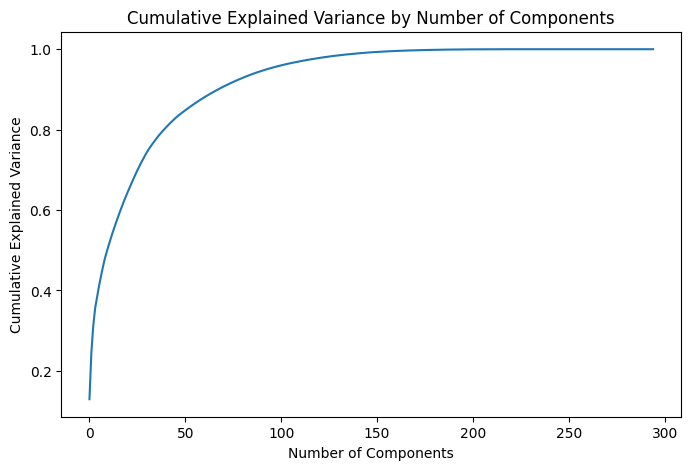

In [343]:
pca = PCA()
pca.fit(df)
pca_data=pca.transform(df)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.show()



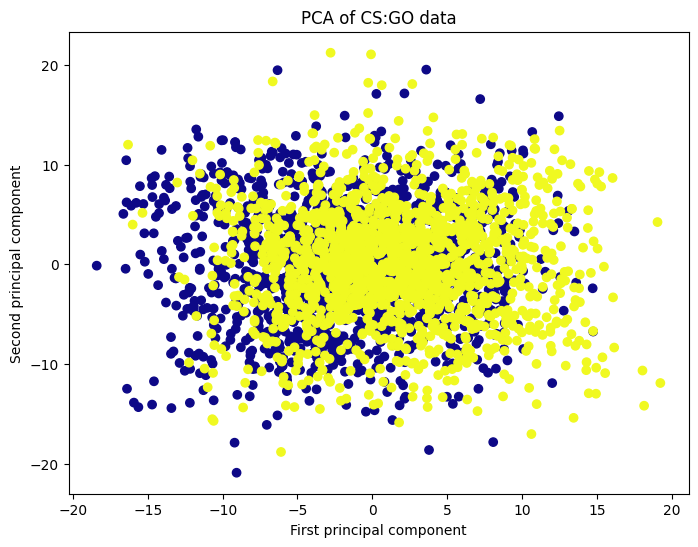

In [344]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df)

plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=df['winner'], cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA of CS:GO data')
plt.show()

Remove highly correlated features

In [345]:
# Step 1: Calculate the correlation matrix
corr_matrix = df.corr().abs()

# Step 2: Identify highly correlated pairs
threshold = 0.7
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Step 3: Drop the features
df_reduced = df.drop(to_drop, axis=1)

df_reduced.head()

,t1_world_rank,t2_world_rank,t1_h2h_win_perc,t1_player1_rating,t1_player1_dmr,t1_player1_apr,t1_player1_spr,t1_player1_opk_ratio,t1_player1_wins_perc_after_fk,t1_player1_is_sniper,...,player_wins_perc_after_fk_avg_diff,player_wins_perc_after_fk_max_diff,t1_player_clutch_win_perc_avg,t2_player_clutch_win_perc_avg,t1_player_clutch_win_perc_max,t2_player_clutch_win_perc_max,t1_player_clutch_win_perc_min,t2_player_clutch_win_perc_min,player_clutch_win_perc_min_diff,winner
0,0.570604,0.563511,-0.077581,-0.077794,0.341513,-0.323080,-1.159974,-0.725623,-1.171127,-0.829509,...,-1.185168,-0.753146,-1.815674,0.474635,-1.772768,-0.010151,-0.928120,0.494056,-1.065008,0
1,-0.510496,0.029324,-0.441980,0.069722,0.407826,0.105616,0.006475,-0.689302,-0.137678,-0.829509,...,1.392539,1.142933,1.441752,-1.813220,-0.199637,-1.696377,1.851676,-0.871935,2.042061,0
2,-0.870862,1.809946,-0.077581,0.069722,-0.188987,0.534312,1.172924,-0.725623,0.126693,1.205532,...,-0.343908,-1.452889,0.205811,0.733252,-0.265106,-0.010151,-0.147696,0.902079,-0.768295,0
3,-0.150129,0.563511,-0.077581,-0.372826,0.385722,1.391703,0.006475,-0.616660,-0.017509,-0.829509,...,-0.850821,-0.098548,-0.504494,0.539498,-0.700869,-0.010151,0.172478,0.494056,-0.228126,0
4,0.030054,1.631884,1.234253,0.659787,0.960430,0.534312,0.589700,-0.761944,0.006525,-0.829509,...,-0.338515,-0.346844,1.447588,0.656681,0.415774,-0.362220,1.765107,1.242098,0.438919,0


Feature selection using RandomForestClassifier



In [346]:
X = df_reduced.drop('winner', axis=1)
y = df_reduced['winner']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

# Select the top 10 most important features
selected_features = feature_importances[:10].index

# Filter your dataset to keep only the selected features
X_selected = X[selected_features]

import matplotlib.pyplot as plt

feature_importances.head(10).sort_values('importance', ascending=True).plot(kind='barh', legend=None)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


data = pd.concat([X_selected, df['winner']], axis=1)
data.head()

Correlational heatmap

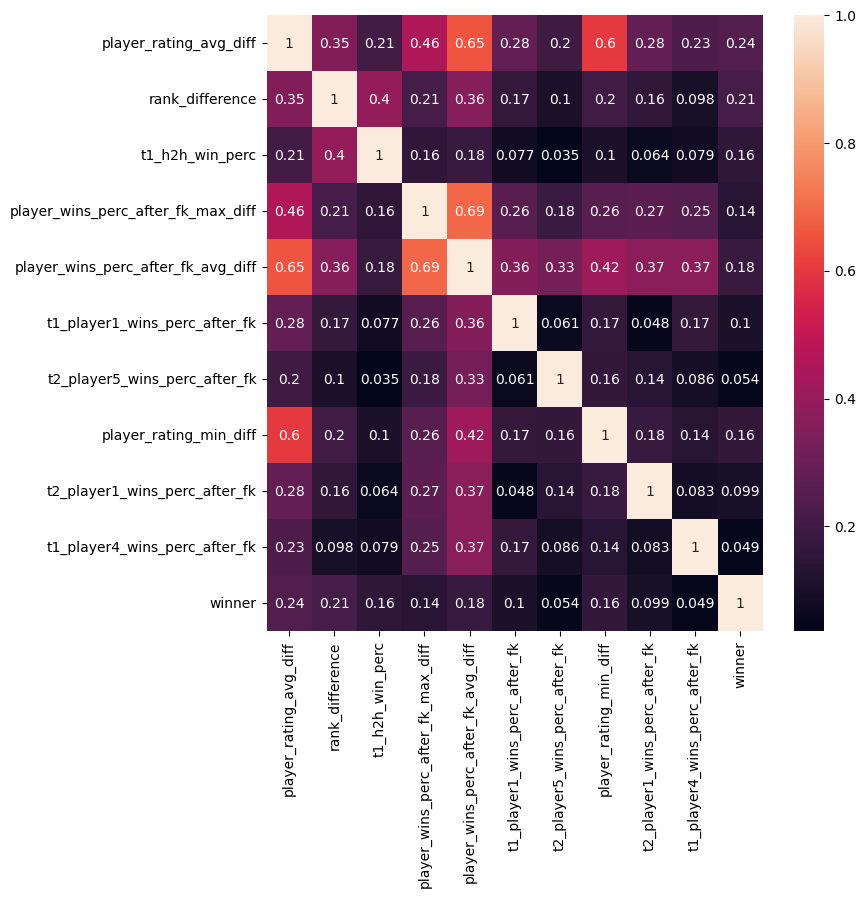

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(data.corr().abs(), annot=True)
plt.show()

Split data to train/test groups

In [ ]:
train, test = np.split(data.sample(frac=1), [int(0.8*len(data))])

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
def split_dataset(dataframe):
    # Separate features (X) and target (y) from the dataframe.
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    # Combine the features and target into a single dataset.
    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

In [ ]:
# Split the dataset into training and testing sets
train, X_train, y_train = split_dataset(train)
test, X_test, y_test = split_dataset(test)

KNN

In [ ]:
# initialize the model
knn_model = KNeighborsClassifier(n_neighbors=6)

# fit the model
knn_model.fit(X_train, y_train)

# predict the target values
y_pred = knn_model.predict(X_test)

# print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.73      0.62       320
           1       0.59      0.38      0.46       325

    accuracy                           0.56       645
   macro avg       0.57      0.56      0.54       645
weighted avg       0.57      0.56      0.54       645



Decision Tree

In [ ]:
# initialize the model
decision_tree_model = DecisionTreeClassifier(max_depth=4)

# fit the model
decision_tree_model.fit(X_train, y_train)

# predict the labels of the test set
y_pred_decision_tree = decision_tree_model.predict(X_test)

# print the classification report
print(classification_report(y_test, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.56      0.80      0.66       320
           1       0.66      0.39      0.49       325

    accuracy                           0.59       645
   macro avg       0.61      0.60      0.58       645
weighted avg       0.61      0.59      0.58       645



Naive Bayes

In [ ]:
# initialize the model
naive_bayes_model = GaussianNB()

# fit the model
naive_bayes_model.fit(X_train, y_train)

# make predictions
y_pred_naive_bayes = naive_bayes_model.predict(X_test)

# print the classification report
print(classification_report(y_test, y_pred_naive_bayes))

              precision    recall  f1-score   support

           0       0.58      0.65      0.62       320
           1       0.61      0.54      0.58       325

    accuracy                           0.60       645
   macro avg       0.60      0.60      0.60       645
weighted avg       0.60      0.60      0.60       645



Random Forests

In [ ]:
# instantiate the model
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=4)

# fit the model
random_forest_model.fit(X_train, y_train)

# predict the labels of the test set
y_pred_random_forest = random_forest_model.predict(X_test)

# generate the classification report
print(classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.58      0.72      0.64       320
           1       0.64      0.49      0.56       325

    accuracy                           0.60       645
   macro avg       0.61      0.61      0.60       645
weighted avg       0.61      0.60      0.60       645



Logistic Regression

In [ ]:
# Fit logistic regression model
logistic_regression_model = LogisticRegression(max_iter=1000)

# Train logistic regression model
logistic_regression_model.fit(X_train, y_train)

# Test logistic regression model
y_pred_logistic_regression = logistic_regression_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_logistic_regression))

              precision    recall  f1-score   support

           0       0.60      0.69      0.64       320
           1       0.64      0.54      0.58       325

    accuracy                           0.61       645
   macro avg       0.62      0.61      0.61       645
weighted avg       0.62      0.61      0.61       645



XGBoost

In [ ]:
#initiate the model
xgboost_model = XGBClassifier(n_estimators=40, max_depth=3)

#fit the model
xgboost_model.fit(X_train, y_train)

#predict the test set
y_pred_xgboost = xgboost_model.predict(X_test)

#print the classification report
print(classification_report(y_test, y_pred_xgboost))

              precision    recall  f1-score   support

           0       0.56      0.70      0.62       320
           1       0.61      0.47      0.53       325

    accuracy                           0.58       645
   macro avg       0.59      0.58      0.58       645
weighted avg       0.59      0.58      0.58       645

